In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [195]:
target_col = 'Outcome'

def load_diabetes_df(split_test=False, split_test_elements=None):
    df_diabetes = pd.read_csv('diabetes.csv')
   
    df_diabetes = df_diabetes.sample(frac=1, ignore_index=True)

    if split_test:
        splits = {'train':[], 'test':[]}
        df_diabetes = (df_diabetes,)
        for vectors in df_diabetes:
            df_train, df_test = vectors.iloc[:-1*split_test_elements], vectors.iloc[-1*split_test_elements:].reset_index(drop=True)
            splits['train'].append(df_train)
            splits['test'].append(df_test)
        
        df_diabetes = tuple(splits['train'] + splits['test'])

    return df_diabetes


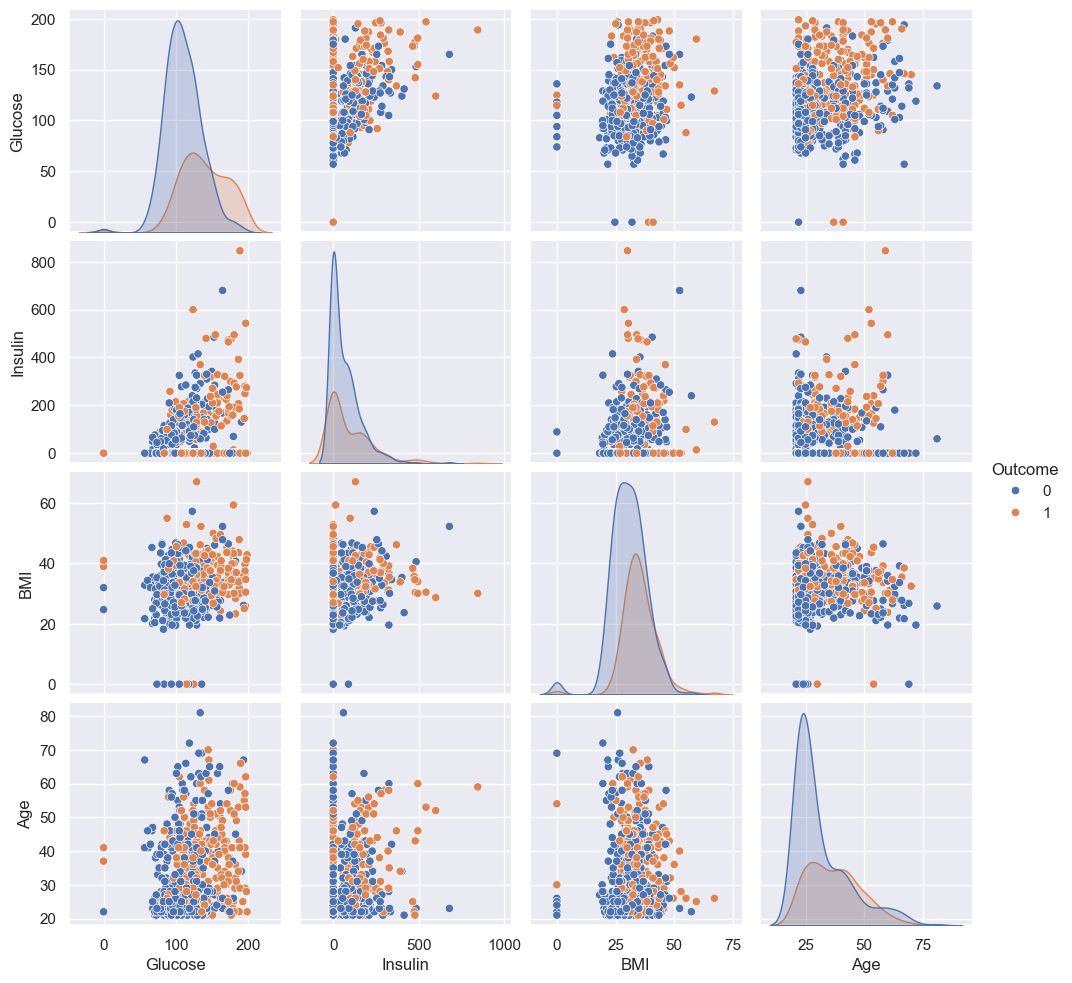

In [196]:
df_train, df_test = load_diabetes_df(split_test=True, split_test_elements=150)
df_train, df_test = df_train.drop(['Pregnancies'], axis=1), df_test.drop(['Pregnancies'], axis=1)


graph = ['Glucose','Insulin','BMI','Age','Outcome']
sns.set()
print(sns.pairplot(df_train[graph],hue='Outcome', diag_kind='kde'))


In [197]:
dict_imputation = dict()

for col in df_train.columns:
    if col == target_col:
        continue
    dict_imputation[col] = round(df_train[col].mean(),3)
    df_train.fillna({col: dict_imputation[col]},inplace=True)
    df_test.fillna({col: dict_imputation[col]},inplace=True)

dict_imputation

{'Glucose': np.float64(120.372),
 'BloodPressure': np.float64(68.66),
 'SkinThickness': np.float64(20.646),
 'Insulin': np.float64(76.222),
 'BMI': np.float64(32.131),
 'Pedigree': np.float64(0.464),
 'Age': np.float64(33.351)}

In [198]:
dict_normalize = dict()
for col in df_train.columns:
    if col == target_col:
        continue
    dict_normalize[col] = (df_train[col].min(),df_train[col].max())
    df_train[col] = df_train[col].apply(lambda x : (x - dict_normalize[col][0])/(dict_normalize[col][1] - dict_normalize[col][0]))
    df_test[col] = df_test[col].apply(lambda x : (x - dict_normalize[col][0])/(dict_normalize[col][1] - dict_normalize[col][0]))

In [199]:
df_train

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,0.638191,0.377049,0.212121,0.395981,0.512668,0.041845,0.016667,0
1,0.577889,0.491803,0.393939,0.000000,0.502235,0.071307,0.316667,1
2,0.502513,0.557377,0.252525,0.083924,0.573770,0.105038,0.083333,0
3,0.532663,0.590164,0.000000,0.000000,0.384501,0.055081,0.100000,0
4,0.537688,0.606557,0.303030,0.118203,0.500745,0.139197,0.033333,0
...,...,...,...,...,...,...,...,...
613,0.497487,0.557377,0.383838,0.000000,0.488823,0.028608,0.200000,0
614,0.678392,0.000000,0.000000,0.000000,0.779434,0.213493,0.316667,1
615,0.542714,0.655738,0.000000,0.000000,0.402385,0.077284,0.516667,1
616,0.623116,0.606557,0.000000,0.000000,0.506706,0.060632,0.283333,1


In [200]:
def knn_class(df_train, k, target_col,observation, use_weighted_vote ):
   validation = df_train[target_col].copy()
   train = df_train.drop([target_col], axis=1)
   observed_clean = observation.drop([target_col])
   norms = np.linalg.norm((train-observed_clean).astype(float), axis=1)
   idx = np.argpartition(norms,k)[:k]
   if use_weighted_vote:
      weighted_sum = {key: 0 for key in validation.value_counts().index}
      weights = 1/(norms**2)
      for i in idx:
         weighted_sum[validation[i]] += weights[i]
      return max(weighted_sum, key=weighted_sum.get)
   nearest_types = validation.take(idx)
   return nearest_types.mode()[0]

In [203]:
poss_k = range(1,150) # possible k's
acc_k_majority = list(np.zeros(len(poss_k))) # Accuracy for each value of k using majority voting
acc_k_weighted = list(np.zeros(len(poss_k))) # Accuracy for each value of k using weighted voting

def get_acc(s_1, s_2):
    return sum(s_1 == s_2)/len(s_1)

for j, k in enumerate(poss_k):
    majority_predicitons = np.array([])
    weighted_predictions = np.array([])
    for i in range(len(df_test)):
        majority_predicitons = np.append(majority_predicitons,knn_class(df_train, k, target_col,df_test.iloc[i], False))
        weighted_predictions = np.append(weighted_predictions,knn_class(df_train, k,target_col,df_test.iloc[i], True))
    acc_k_majority[j] = get_acc(majority_predicitons,df_test[target_col])
    acc_k_weighted[j] = get_acc(weighted_predictions,df_test[target_col])

print(f"Max Accuracy: {max(acc_k_majority)*100:.2f}; For k-value of {poss_k[np.argmax(acc_k_weighted, keepdims=True)[0]]} ")


Max Accuracy: 77.33; For k-value of 16 


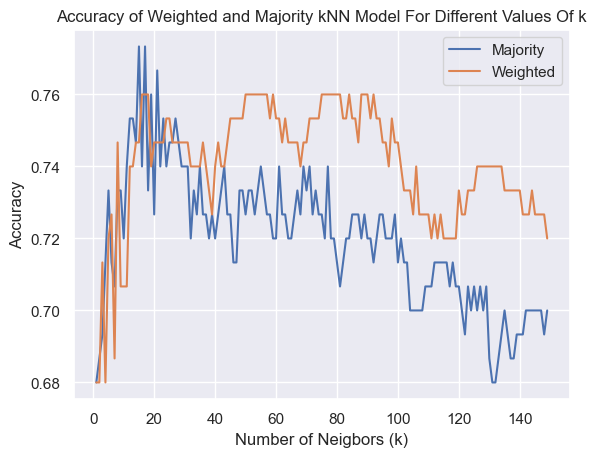

In [204]:
plt.plot(poss_k,acc_k_majority, label='Majority')
plt.plot(poss_k,acc_k_weighted,label='Weighted')
plt.xlabel('Number of Neigbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy of Weighted and Majority kNN Model For Different Values Of k')
plt.legend()
plt.show()